<a href="https://colab.research.google.com/github/jiinpark21/ESAA_24-2/blob/main/6%EC%A3%BC%EC%B0%A8_%EA%B3%BC%EC%A0%9C_1007_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EC%84%9D_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 머신러닝 완벽 가이드 개정2판 ch8.10-11

p.566-583

#[Chapter 8] 텍스트분석

## 8.10 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

- train_id : 데이터 id
- name : 제품명
- item_condition_id : 판매자가 제공하는 제품 상태
- category_name : 카테고리 명
- brand_name : 브랜드 이름
- price : 제품 가격 -> 타깃값
- shipping : 배송비 무료 여부, 1은 무료, 0은 유료
- item_description : 제품에 대한 설명

- item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀 수행

### 데이터 전처리

In [1]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [2]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- brand_name 칼럼 : 매우 많은 Null 값

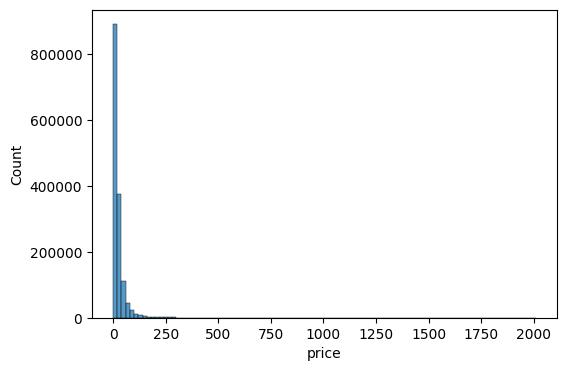

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

- price 칼럼 : 데이터 값이 왜곡된 상태로 분포

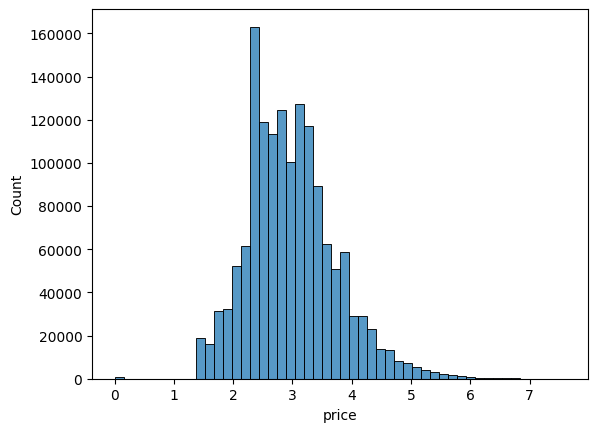

In [4]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

- 로그 변환 이후, 비교적 정규 분포에 가까운 데이터가 됨

In [5]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [6]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형:
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


- Shipping 칼럼 : 값이 비교적 균일함
- item_condition_id 칼럼 : 1,2,3 값이 주를 이룸

In [7]:
boolean_cond = mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

- description에 대한 별도 설명이 없는 경우 -> No description yet
  - Null과 마찬가지로 의미 있는 속성값으로 사용 불가

In [8]:
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트로 반환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대,중,소 칼럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형 : \n', mercari_df['cat_dae'].value_counts())
print('중분류 개수 :', mercari_df['cat_jung'].nunique())
print('소분류 개수 :', mercari_df['cat_so'].nunique())

대분류 유형 : 
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 개수 : 114
소분류 개수 : 871


- category_name : '/'로 분리된 카테고리를 하나의 문자열로 나타냄
  - 따라서 '/'를 기준으로 단어 분리 -> split_cat()

In [9]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 합니다.
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


- brand_name, category_name, item_description 칼럼의 Null 값은 일괄적으로 'Other Null'로 변경

### 피처 인코딩과 피처 벡터화

- 선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로 원-핫 인코딩 적용
- 비교적 짧은 텍스트의 경우 Count 기반의 벡터화
- 긴 텍스트는 TD-IDF 기반의 벡터화 적용

In [10]:
print('brand name의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 :\n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수 : 4810
brand name sample 5건 :
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


- brand_name : 원-핫 인코딩

In [11]:
print('name의 종류 건수 :', mercari_df['name'].nunique())
print('name sample 7건 :\n', mercari_df['name'][:7])

name의 종류 건수 : 1225273
name sample 7건 :
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


- name : 종류와 데이터 개수에 차이가 많이 나지 않으므로 개별적으로 거의 고유한 상품명을 가짐을 알 수 있음
  - 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 되어 있음
  - 따라서, Count 기반 피처 벡터화
- category_name : 원-핫 인코딩 적용
- shipping, item_condition_id : 모두 원-핫 인코딩 적용

In [12]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


- 문자열의 크기가 크므로, item_description 칼럼은 TF-IDF 변환

In [13]:
mercari_df['item_description']

,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
2,"Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!"
3,New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
4,Complete with certificate of authenticity
...,...
1482530,"Lace, says size small but fits medium perfectly too. Never used. Super cute for all occasions ***not free people but looks exact"
1482531,Little mermaid handmade dress never worn size 2t
1482532,"Used once or twice, still in great shape."
1482533,There is 2 of each one that you see! So 2 red 2 orange and 2 of the big red and orange ones! They are from world market!


In [14]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

- name : CountVectorizer
- item_description : TfidfVectorizer

In [15]:
print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


In [16]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

- 원-핫 인코딩 : OneHotEncoder, LabelBinarizer
  - LabelBinarizer : 희소 행렬 형태의 원-핫 인코딩 변환 지원 -> sparse_out = True로 설정

In [17]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_itme_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_itme_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


- 인코딩 변환된 데이터 세트는 CSR 형태로 변환된 csr_matrix 타입
- 인코딩 칼럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 크게 문제되지 X

In [18]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합.
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 160698)


0

- 사이파이 패키지 sparse 모듈의 hstack() 함수 이용하여 개별 칼럼으로 만들어진 희소 행렬 결합

### 릿지 회귀 모델 구축 및 평가

- 평가지표 : RMSLE
  - 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류 값이 커지는 것을 억제하기 위해 RMSLE 사용
  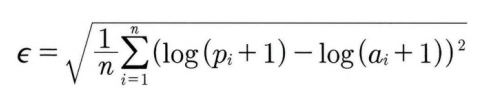

- price 칼럼을 로그 변환하였으므로, 학습 모델을 통해 예측된 price 값은 지수 변환을 통해 원복 필요(exmpm1)

In [19]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):

  # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요.
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  # rmsle로 RMSLE 값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

In [20]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
  X = hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],
                                                      test_size=0.2, random_state=156)
  # 모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

In [21]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.49844642739555695
Item Description을 포함한 rmsle 값: 0.4681338129466161


- Item description을 포함했을 때, rmsle 값이 많이 감소
  - Item description 영향이 중요함을 알 수 있음

### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [27]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 45.712908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068409
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 65338
[LightGBM] [Info] Start training from score 2.979514
LightGBM rmsle 값: 0.4563757852336539


- Ridge보다 예측성능이 더 나아짐

In [28]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensembel한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensembel한 최종 rmsle 값: 0.4465714193914377


- Ridge와 LGBM 앙상블 : 예측성능이 더 개선됨

## 8.11 정리

- 머신러닝 기반의 텍스트 분석 프로세스
  1. 텍스트 정규화 작업
  2. 단어들을 피처 벡터화로 변환
  3. 생성된 피처 벡터 데이터 세트에 머신러닝 모델을 학습, 예측, 평가

  -  텍스트 정규화 작업
    - 텍스트 클렌징
    - 대소문자 변경
    - 단어 토큰화
    - 의미 없는 단어 필터링
    - 어근 추출
  - 피처 벡터화(BOW)
    - Count 기반
    - TF-IDF 기반 : 일반적으로 문서의 문장이 긴 경우 더 정확한 결과 도출
    - 피처 벡터 데이터 세트 : 희소 행렬

- 텍스트 분류
  - 문서들을 피처 벡터화한 후, 로지스틱 회귀를 적용해 문서를 지도학습 방식으로 예측 분류

- 감성 분석
  - 지도 학습 기반으로 긍정/부정 이진 분류 이용한 방식
  - SentiWordNet, Vader와 같은 감성 사전 Lexicon 이용한 방식

- 토픽 모델링
  - LDA(Latent Dirichlet Allocation)을 이용해 뉴스 그룹 내의 많은 문서들이 공통적으로 가지는 토픽 추출
- 텍스트 군집화
  - K-평균 군집화 이용해 비슷한 문서들끼리 군집화
- 텍스트 유사도 측정
  - 코사인 유사도를 이용해 문서들끼리 얼마나 비슷한지 측정